# 1. Import and Install Dependencies

## 1.1 Install Dependencies

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import librosa

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [2]:
CAPUCHIN_FILE = os.path.join(os.getcwd(), 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join(os.getcwd(), 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [3]:
# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels) 
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Convert TensorFlow tensor to NumPy array
#     wav_np = wav.numpy()
#     sample_rate_np = sample_rate.numpy()
    # Resample using librosa
#     resampled_wav = librosa.resample(wav_np, sample_rate_np, 16000)
    # Convert back to TensorFlow tensor
    resampled_wav_tensor = tf.convert_to_tensor(wav)
    return resampled_wav_tensor

## 2.3 Plot Wave

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

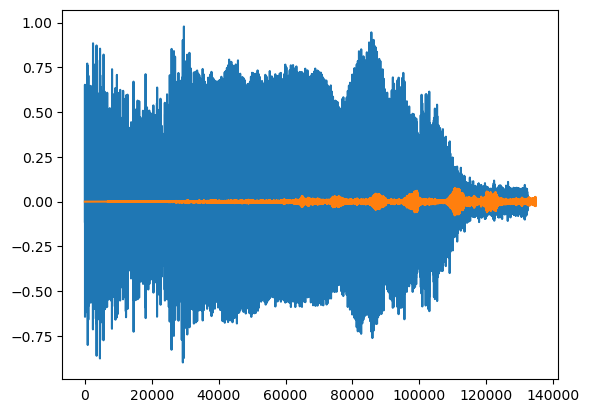

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [7]:
POS = os.path.join(os.getcwd(), 'Parsed_Capuchinbird_Clips')
NEG = os.path.join(os.getcwd(), 'Parsed_Not_Capuchinbird_Clips')
POS

'/Users/rakesh.rai/code/whistles/Parsed_Capuchinbird_Clips'

## 3.2 Create Tensorflow Datasets

In [8]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [10]:
lengths = []
for file in os.listdir(os.path.join(os.getcwd(), 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join(os.getcwd(), 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [11]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=149905>

In [12]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=22050>

In [13]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=220500>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [14]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [16]:
spectrogram, label = preprocess(filepath, label)

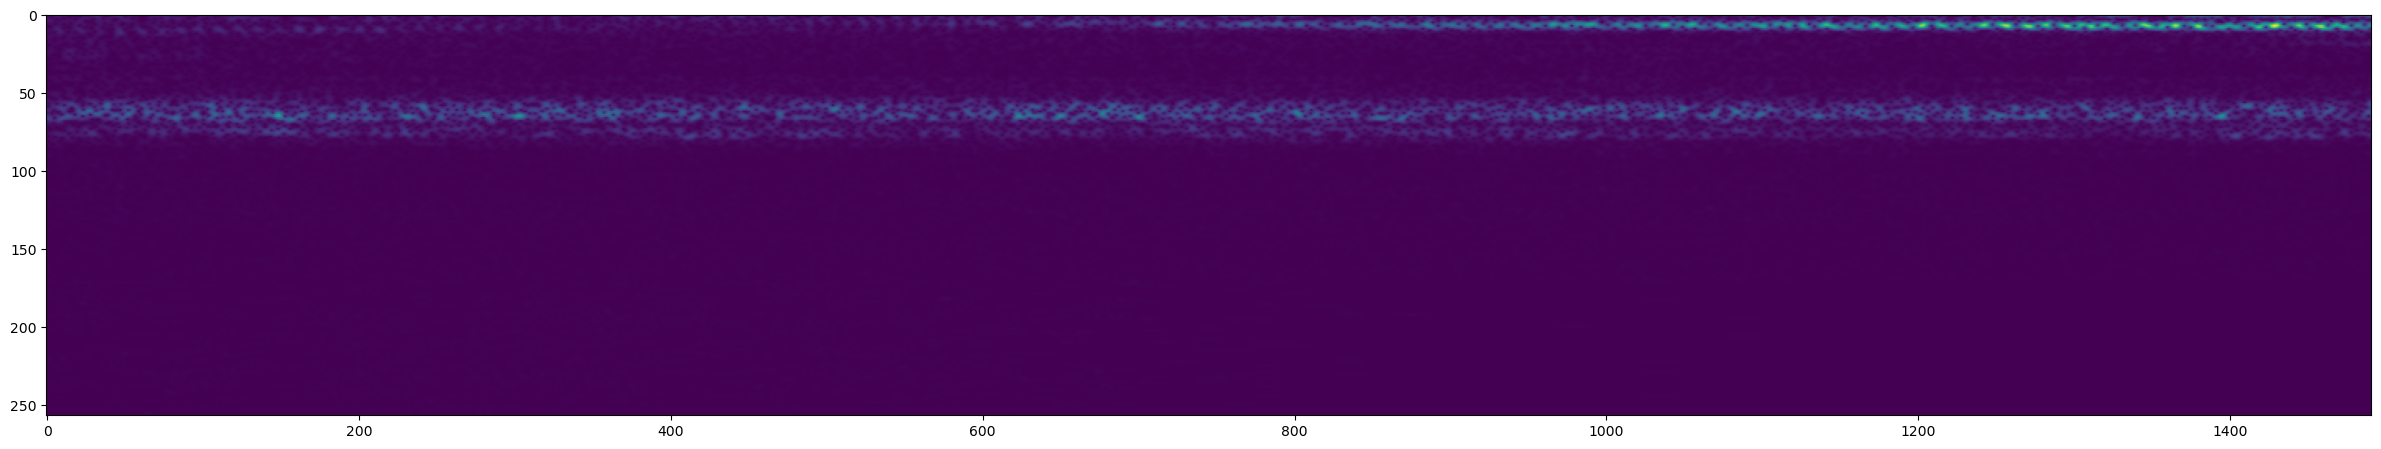

In [17]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [18]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [19]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [20]:
samples, labels = train.as_numpy_iterator().next()

In [21]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [23]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [48]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 117s 3s/step - loss: 8.9472 - recall: 0.7677 - precision: 0.6723 - val_loss: 0.1681 - val_recall: 0.8065 - val_precision: 0.9615
Epoch 2/4
36/36 [==============================] - 94s 3s/step - loss: 0.1059 - recall: 0.9195 - precision: 0.9716 - val_loss: 0.0495 - val_recall: 0.9714 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 95s 3s/step - loss: 0.0435 - recall: 0.9758 - precision: 0.9758 - val_loss: 0.0117 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 102s 3s/step - loss: 0.0177 - recall: 0.9935 - precision: 0.9871 - val_loss: 0.0067 - val_recall: 1.0000 - val_precision: 1.0000


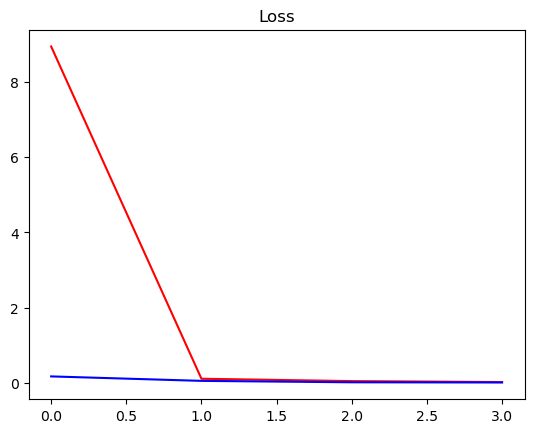

In [49]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

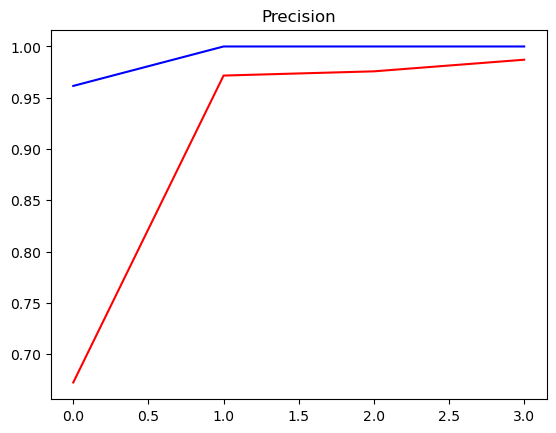

In [50]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

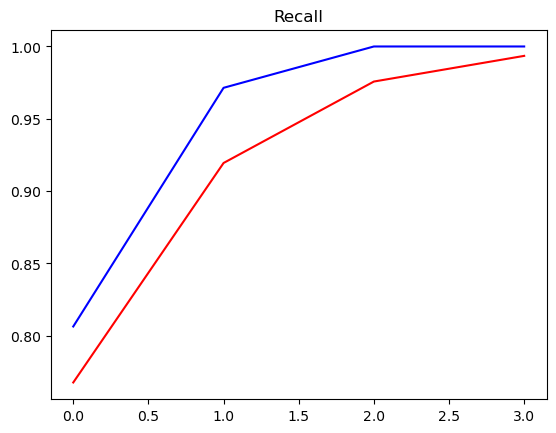

In [51]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [52]:
X_test, y_test = test.as_numpy_iterator().next()

In [53]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 761ms/step


## 8.2 Convert Logits to Classes 

In [54]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [71]:
# def load_mp3_16k_mono(filename):
#     """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
#     res = tfio.audio.AudioIOTensor(filename)
#     # Convert to tensor and combine channels 
#     tensor = res.to_tensor()
#     tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
#     # Extract sample rate and cast
#     sample_rate = res.rate
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Resample to 16 kHz
# #     wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
#     return wav

def load_mp3_16k_mono(filename):
    # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = librosa.load(filename, sr=None, mono=True)
    # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Convert TensorFlow tensor to NumPy array
#     wav_np = wav.numpy()
#     sample_rate_np = sample_rate.numpy()
    # Resample using librosa
#     resampled_wav = librosa.resample(wav_np, sample_rate_np, 16000)
    # Convert back to TensorFlow tensor
    resampled_wav_tensor = tf.convert_to_tensor(wav)
    return resampled_wav_tensor

In [99]:
import IPython.display as ipd
mp3 = os.path.join(os.getcwd(), 'Forest Recordings', 'recording_08.mp3')
ipd.Audio(mp3)

In [100]:
wav = load_mp3_16k_mono(mp3)

In [101]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [102]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [103]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [104]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [105]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

9/9 [==============================] - 9s 861ms/step


## 9.4 Group Consecutive Detections

In [106]:
from itertools import groupby

In [107]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [108]:
calls

25

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [93]:
results = {}
for file in os.listdir(os.path.join(os.getcwd(), 'Forest Recordings')):
    FILEPATH = os.path.join(os.getcwd(),'Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

3/3 [==============================] - 3s 816ms/step


In [94]:
results

{'recording_95.mp3': array([[2.82888966e-08],
        [1.17245622e-20],
        [2.54111439e-21],
        [9.65073301e-20],
        [4.47924711e-14],
        [2.30721928e-10],
        [1.13189571e-11],
        [4.45150399e-05],
        [1.00000000e+00],
        [1.00000000e+00],
        [1.00000000e+00],
        [9.99997735e-01],
        [8.16197695e-13],
        [8.63563943e-10],
        [2.51964899e-12],
        [5.74482275e-14],
        [1.47837861e-14],
        [1.51821142e-13],
        [1.76976239e-10],
        [1.67558496e-16],
        [4.16761836e-16],
        [9.00430963e-17],
        [3.66107505e-10],
        [8.68955241e-10],
        [1.97645650e-10],
        [4.13177892e-09],
        [4.94908337e-09],
        [5.11750142e-10],
        [5.44273293e-10],
        [1.35381401e-10],
        [3.25822101e-18],
        [1.04677664e-22],
        [4.88906959e-22],
        [1.20654772e-15],
        [2.30281159e-12],
        [1.34571021e-09],
        [1.12984504e-10],
        [2.4468879

## 10.2 Convert Predictions into Classes

In [95]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_95.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_81.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

## 10.3 Group Consecutive Detections

In [96]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_95.mp3': 5,
 'recording_81.mp3': 5,
 'recording_56.mp3': 64,
 'recording_42.mp3': 0,
 'recording_43.mp3': 5,
 'recording_57.mp3': 4,
 'recording_80.mp3': 1,
 'recording_94.mp3': 3,
 'recording_82.mp3': 0,
 'recording_96.mp3': 1,
 'recording_69.mp3': 1,
 'recording_41.mp3': 0,
 'recording_55.mp3': 0,
 'recording_54.mp3': 4,
 'recording_40.mp3': 1,
 'recording_68.mp3': 1,
 'recording_97.mp3': 4,
 'recording_83.mp3': 0,
 'recording_87.mp3': 24,
 'recording_93.mp3': 5,
 'recording_44.mp3': 1,
 'recording_50.mp3': 0,
 'recording_78.mp3': 73,
 'recording_79.mp3': 0,
 'recording_51.mp3': 3,
 'recording_45.mp3': 3,
 'recording_92.mp3': 0,
 'recording_86.mp3': 68,
 'recording_90.mp3': 0,
 'recording_84.mp3': 71,
 'recording_53.mp3': 0,
 'recording_47.mp3': 63,
 'recording_46.mp3': 65,
 'recording_52.mp3': 0,
 'recording_85.mp3': 0,
 'recording_91.mp3': 0,
 'recording_09.mp3': 0,
 'recording_35.mp3': 0,
 'recording_21.mp3': 1,
 'recording_20.mp3': 0,
 'recording_34.mp3': 4,
 'recordi

# 11. Export Results

In [97]:
import csv

In [98]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])